In [76]:
import scipy.io, os, torch
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_loc = ('gdrive/MyDrive/colab/ex4data1.mat')
else:
    file_loc = 'ex4data1.mat'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mat = scipy.io.loadmat(file_loc)
X = mat['X']
y = mat['y']
y = np.where(y==10,0,y)
print(device)

cpu


In [77]:
X_a = X.reshape(-1,20,20, order='F')
X_b = torch.from_numpy(X_a.astype(np.float32)).to(device)
y_b = (torch.from_numpy(y.astype(int))).to(device)
dataset = TensorDataset(X_b, y_b)

test_ratio = 0.2  # 20% data split into test dataset
n_sample = X_a.shape[0]
test_size = int(n_sample * test_ratio)
train_size = n_sample - test_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])
train_dataloader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_size)
for X_C in train_dataloader:
    X_train = X_C[0].view(-1,1,20,20).to(device)
    y_train = X_C[1].type(torch.LongTensor).flatten().to(device)
for X_D in test_dataloader:
    X_test = X_D[0].view(-1,1,20,20).to(device)
    y_test = X_D[1].type(torch.LongTensor).flatten().to(device)

In [78]:
class CNN_model(nn.Module):
    def __init__(self,input_channel,classes):
        super(CNN_model,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=20,kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=200, out_features=50)
        self.relu3 = nn.ReLU()
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=50, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x_val):
        z = self.conv1(x_val)
        z = self.relu1(z)
        z = self.maxpool1(z)
        z = self.conv2(z)
        z = self.relu2(z)
        z = self.maxpool2(z)
        z = torch.flatten(z,1)
        z = self.fc1(z)
        z = self.relu3(z)
        z = self.fc2(z)
        z = self.logSoftmax(z)
        return z

In [83]:
model = CNN_model(1,10).to(device)
loss = nn.NLLLoss()
epoch = int(5)
model.load_state_dict(torch.load('model.pt',map_location=torch.device('cpu'))) # pretrainned on google colab
model.eval()

CNN_model(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [84]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for i in range(epoch):
    out = model(X_train)
    J = loss(out,y_train)
    J.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%1==0:
        with torch.no_grad():
            test_out = model(X_test)
            acc_test = ((torch.argmax(test_out,dim=1).flatten()==y_test).sum().item()) * (100/1000)
            acc = ((torch.argmax(out,dim=1).flatten()==y_train).sum().item()) * (100/4000)
        print(f'Epoch number {i} : Loss = {J:.5f}, accuracy train = {acc:.3f} %, test = {acc_test:.3f} %')
# torch.save(model.state_dict(),'model.pt')

Epoch number 0 : Loss = 0.02493, accuracy train = 99.500 %, test = 99.400 %
Epoch number 1 : Loss = 0.02696, accuracy train = 99.400 %, test = 99.400 %
Epoch number 2 : Loss = 0.01967, accuracy train = 99.575 %, test = 99.500 %
Epoch number 3 : Loss = 0.02017, accuracy train = 99.600 %, test = 99.500 %
Epoch number 4 : Loss = 0.01873, accuracy train = 99.575 %, test = 99.400 %


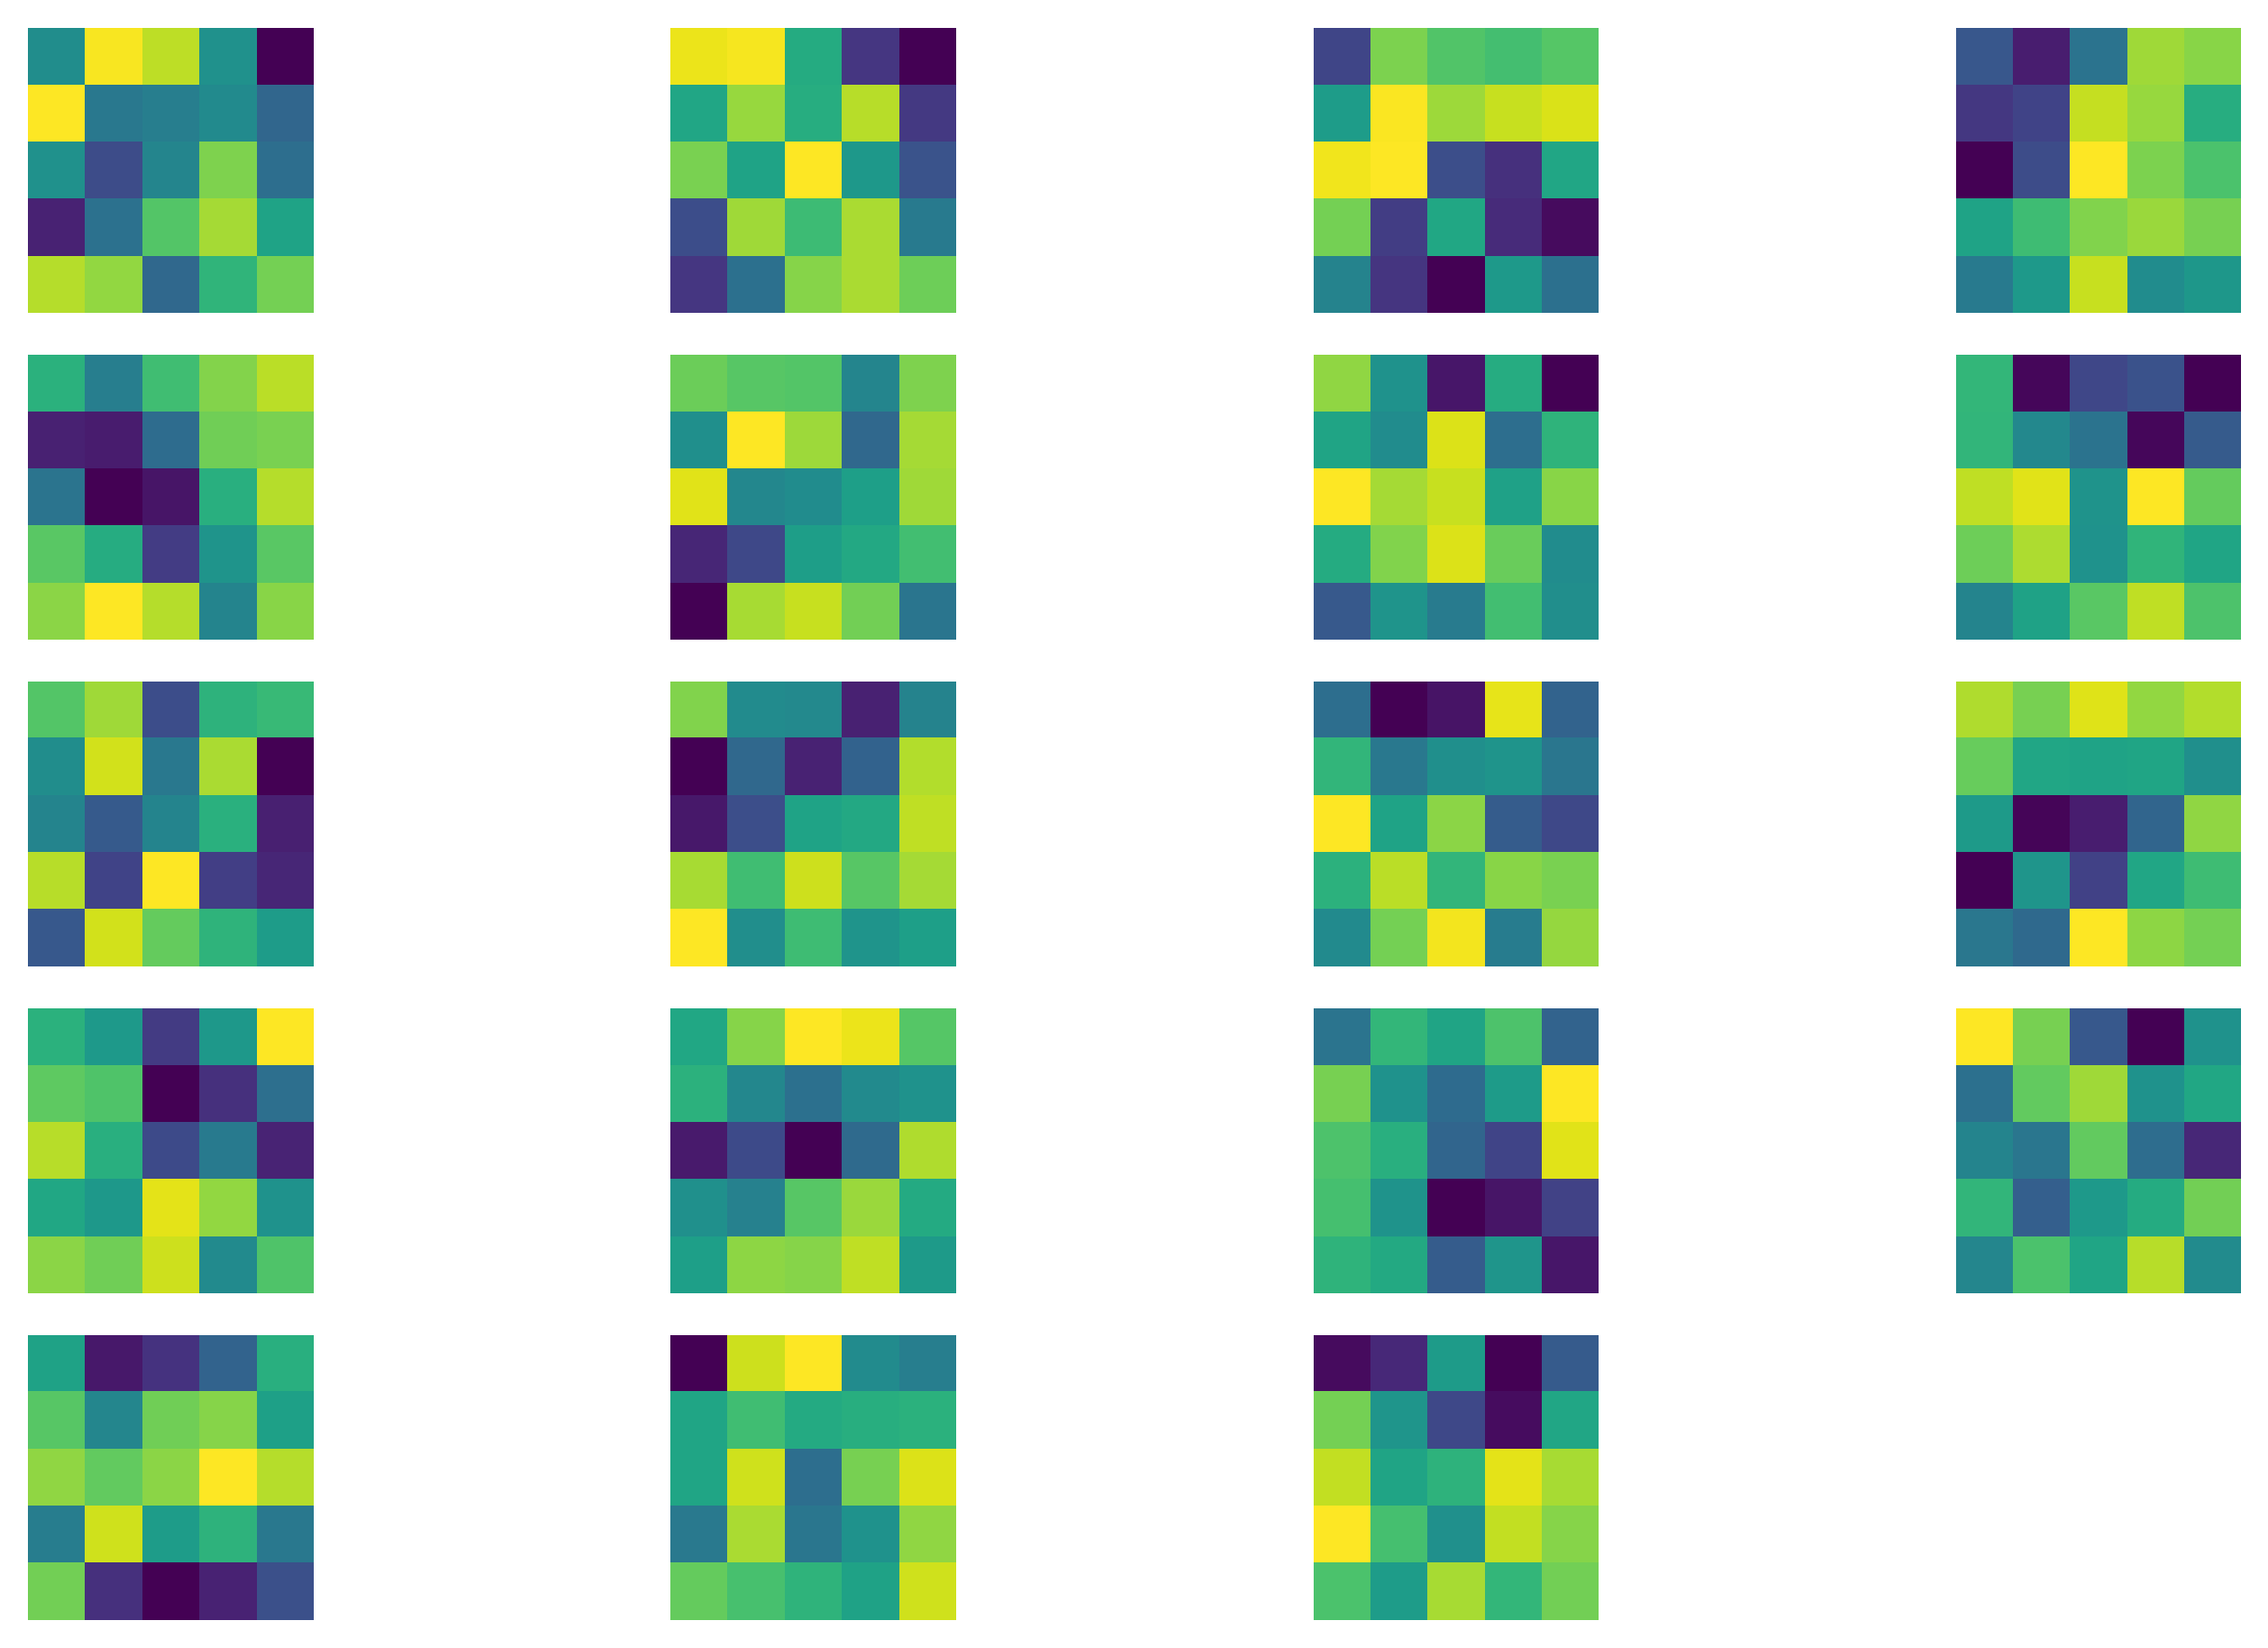

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=300)
for i in range(19):
    plt.subplot(5,4,i+1)
    plt.imshow(model.conv1.weight.data[i,0,:,:])
    plt.axis('off')
    plt.tight_layout()
